# Projet

## Mise en place de l'environnement

In [ ]:
!pip install numpy pandas matplotlib tensorflow scikit-learn mlflow

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle



## Exploration des données - CIFAR-100

### Chargement des données

Le jeu de données CIFAR-100 est chargé à l'aide de la bibliothèque `tensorflow.keras`.
Il contient :
- **Nombre total d'images** : 60 000.
  - **Entraînement** : 50 000 images.
  - **Test** : 10 000 images.
- **Caractéristiques des données** :
  - Chaque image a une taille de **32x32 pixels** avec **3 canaux de couleur** (RVB).
  - Les images appartiennent à **100 classes fines** (catégories détaillées) réparties de manière équilibrée.
- **Représentation des caractéristiques** :
  - Les images peuvent être utilisées sous forme de matrices 3D (32x32x3) ou transformées en vecteurs plats (3072 valeurs).



In [2]:
# Chargement des données
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Aperçu des dimensions des données
print(f"Dimensions des images d'entraînement : {x_train.shape}")
print(f"Dimensions des labels d'entraînement : {y_train.shape}")
print(f"Dimensions des images de test : {x_test.shape}")
print(f"Dimensions des labels de test : {y_test.shape}")

Dimensions des images d'entraînement : (50000, 32, 32, 3)
Dimensions des labels d'entraînement : (50000, 1)
Dimensions des images de test : (10000, 32, 32, 3)
Dimensions des labels de test : (10000, 1)


### Visualisation des données

Affichons quelques exemples d'images avec leurs labels pour comprendre leur structure visuelle et vérifier leur qualité.

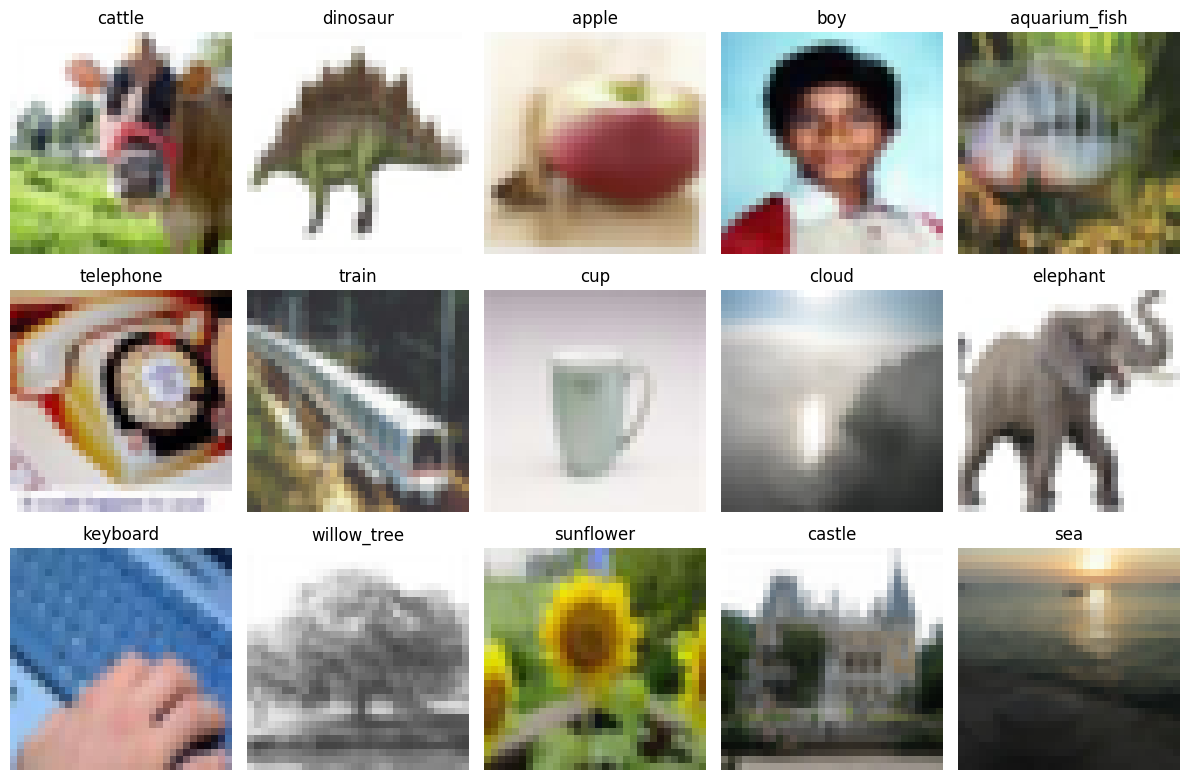

In [3]:
# Liste des classes dans CIFAR-100 (labels "fine")
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Visualisation d'échantillons
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.set_title(f"{class_names[y_train[i][0]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Prétraitement des données - CIFAR-100


### Vérification des déséquilibres
Bien que CIFAR-100 soit équilibré par défaut, on peut visualiser la répartition des classes pour confirmation :

In [4]:
# Vérification de l'équilibre des classes
train_counts = pd.Series(np.squeeze(y_train)).value_counts()
test_counts = pd.Series(np.squeeze(y_test)).value_counts()

# Chaque classe devrait avoir un nombre similaire d'instances
assert (train_counts.min() == train_counts.max()), "Les classes d'entraînement ne sont pas équilibrées."
assert (test_counts.min() == test_counts.max()), "Les classes de test ne sont pas équilibrées."

print("Les classes sont équilibrées dans les données d'entraînement et de test.")


Les classes sont équilibrées dans les données d'entraînement et de test.


### Normalisation des pixels

Les pixels des images sont initialement compris dans la plage **[0, 255]**. Nous les normalisons dans une plage **[0, 1]** pour faciliter la convergence des modèles et uniformiser les données.

In [5]:
# Normalisation des pixels
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"Valeurs après normalisation : Min = {x_train.min()}, Max = {x_train.max()}")


Valeurs après normalisation : Min = 0.0, Max = 1.0


### Nouvelle section

In [6]:
# Aplatir les images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

## CNN_RESNET18 

### Recherche d'hyperparamètres et validation croisée pour le CNN_RESNET18


1. **Augmentation des données :**
   - Les images du dataset sont augmentées à l'aide de transformations comme la rotation, le décalage, le cisaillement et la symétrie horizontale pour augmenter la diversité des données d'entraînement.

2. **Construction d'un modèle CNN RESNET18 paramétrable :**
   - Une fonction générique (`create_model`) permet de construire dynamiquement un CNN avec différents hyperparamètres, tels que le nombre de filtres dans les couches convolutionnelles, les taux de dropout, et le nombre de neurones dans les couches entièrement connectées.
     

3. **Recherche d'hyperparamètres :**
   - Utilisation de **Keras Tuner** pour effectuer une recherche en grille **(*Random search*)** des meilleurs hyperparamètres.

4. **Validation croisée K-Fold :**
   - Le dataset est divisé en 3 sous-ensembles (folds), et la validation croisée est utilisée pour évaluer la robustesse du modèle.

5. **Suivi et journalisation des expérimentations avec MLflow :**
   - Les hyperparamètres, les métriques (précision et perte), ainsi que les modèles entraînés sont enregistrés dans un serveur **MLflow**, permettant de suivre et comparer les résultats des différents folds.

6. **Analyse des résultats :**
   - Les précisions des 3 folds sont agrégées pour calculer une précision moyenne et son écart-type, fournissant une évaluation globale de la performance du modèle.

In [8]:
import mlflow
import mlflow.keras
from sklearn.model_selection import KFold
import keras_tuner as kt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import layers, models


# Initialize Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    shear_range=0.05
)
datagen.fit(x_train)

# Initialize MLflow

mlflow.set_experiment("CIFAR100_CNN_RESNET18_GridSearch")

# Define model creation function
def create_model(hp):
    # Load ResNet50 without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # Add custom top layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(
        hp.Int('units', min_value=64, max_value=512, step=64), 
        activation='relu'
    )(x)
    x = layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(100, activation='softmax')(x)  # CIFAR-100 has 100 classes

    # Build the model
    model = models.Model(inputs=base_model.input, outputs=outputs)

    # Hyperparameter tuning for optimizer and learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_accuracies = []
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Fold {fold + 1}/3")
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize Keras Tuner
    tuner = kt.RandomSearch(
        create_model,
        objective='val_accuracy',
        max_trials=5,
        directory=f'./keras_tuner_dir_fold_{fold + 1}',
        project_name='cifar100_CNN_RESNET18_gridsearch'
    )

    # Hyperparameter tuning
    tuner.search(
        x_train_fold,
        y_train_fold,
        epochs=10,  # Use a fixed number of epochs
        validation_data=(x_val_fold, y_val_fold),
        batch_size=64,
        callbacks=[early_stop]
    )

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Meilleurs hyperparamètres pour le Fold {fold + 1} : {best_hps.values}")

    best_model = tuner.hypermodel.build(best_hps)

    # Log results in MLflow
    with mlflow.start_run(run_name=f"Fold_{fold + 1}"):
        mlflow.log_params(best_hps.values)

        history = best_model.fit(
            x_train_fold,
            y_train_fold,
            epochs=10,
            batch_size=64,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stop]
        )

        for epoch, acc in enumerate(history.history['val_accuracy']):
            mlflow.log_metric("val_accuracy", acc, step=epoch)

        for epoch, loss in enumerate(history.history['val_loss']):
            mlflow.log_metric("val_loss", loss, step=epoch)

        mlflow.keras.log_model(best_model, "model")

    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy pour le Fold {fold + 1} : {fold_accuracy}")

# Log summary in MLflow
with mlflow.start_run(run_name="Final_Summary"):
    mlflow.log_metric("mean_accuracy", np.mean(fold_accuracies))
    mlflow.log_metric("std_accuracy", np.std(fold_accuracies))

print(f"Accuracies des 3 folds : {fold_accuracies}")
print(f"Accuracy moyenne : {np.mean(fold_accuracies)}")
print(f"Écart-type des accuracies : {np.std(fold_accuracies)}")


Trial 5 Complete [00h 02m 13s]
val_accuracy: 0.22260890901088715

Best val_accuracy So Far: 0.43969759345054626
Total elapsed time: 00h 12m 41s
Meilleurs hyperparamètres pour le Fold 3 : {'units': 384, 'dropout': 0.2, 'learning_rate': 0.00041670437570096735, 'optimizer': 'adam'}
Epoch 1/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - accuracy: 0.1246 - loss: 4.1355 - val_accuracy: 0.0199 - val_loss: 6.0087
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3493 - loss: 2.6071 - val_accuracy: 0.2974 - val_loss: 2.8725
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.4234 - loss: 2.2198 - val_accuracy: 0.3624 - val_loss: 2.5431
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.4951 - loss: 1.8815 - val_accuracy: 0.4077 - val_loss: 2.3587
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.5354 - loss: 1.7062 - val_accuracy: 0.4241 - val_loss: 2.2733


2024/12/10 20:36:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/10 20:36:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpypt2w9fw/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/10 20:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy pour le Fold 3 : 0.4240969717502594
Accuracies des 3 folds : [0.08843822777271271, 0.5068698525428772, 0.4240969717502594]
Accuracy moyenne : 0.33980168402194977
Écart-type des accuracies : 0.18092452902034192


### Récupération des meilleurs hyperparamètres
L les meilleurs hyperparamètres identifiés par **Keras Tuner** après la recherche. Les hyperparamètres optimaux sont récupérés avec `get_best_hyperparameters` et affichés pour analyse. Ces valeurs peuvent être utilisées pour construire le modèle final.


In [9]:
# Récupére les meilleurs hyperparamètres du tuner après la validation croisée
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Affiche les meilleurs hyperparamètres
print("Meilleurs hyperparamètres sélectionnés :")
print(best_hps.values)

Meilleurs hyperparamètres sélectionnés :
{'units': 384, 'dropout': 0.2, 'learning_rate': 0.00041670437570096735, 'optimizer': 'adam'}


### Construction du modèle final
Utilations des meilleurs hyperparamètres pour reconstruire le modèle CNN avec la fonction `create_cnn_model` et affiche son résumé pour validatio

In [10]:
# Construit le modèle avec les meilleurs hyperparamètres
final_model = create_model(best_hps)

# Résumé du modèle reconstruit
final_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 24,413,028 (93.13 MB)

 Trainable params: 24,359,908 (92.93 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Callbacks pour l'entraînement

- **ReduceLROnPlateau** : Réduit le taux d'apprentissage de moitié si la perte de validation stagne pendant 3 epochs.
- **EarlyStopping** : Arrête l'entraînement après 5 epochs sans amélioration de la précision de validation, en restaurant les meilleurs poids.


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Callback pour réduire le taux d'apprentissage si la perte de validation ne diminue pas
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback pour arrêter l'entraînement si la précision de validation ne s'améliore pas
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

### Division des données

Les données d'entraînement sont divisées en un ensemble d'entraînement et un ensemble de validation **(10% des données)**, tout en conservant la stratification des classes.

In [12]:
x_train1, x_val, y_train1, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Dimensions de l'entraînement : {x_train1.shape}")
print(f"Dimensions de la validation : {x_val.shape}")


Dimensions de l'entraînement : (45000, 32, 32, 3)
Dimensions de la validation : (5000, 32, 32, 3)


### Entraînement et suivi avec MLflow

- **Journalisation des hyperparamètres** : Les paramètres clés de l'entraînement (batch size, epochs, optimizer, etc.) et les meilleurs hyperparamètres sont enregistrés avec **MLflow**.
- **Entraînement du modèle** : Le modèle final est entraîné sur les données augmentées avec suivi des métriques (précision et perte) pour l'entraînement et la validation.
- **Enregistrement des résultats** :
  - Les métriques par epoch sont journalisées dans MLflow.
  - Les courbes d'apprentissage (précision et perte) sont sauvegardées et ajoutées aux artefacts de l'expérience.
- **Sauvegarde du modèle final** : Le modèle entraîné est enregistré dans MLflow pour une utilisation future.


In [15]:
with mlflow.start_run(run_name="model_training"):
    # Parameters to log
    params = {
        "batch_size": 64,
        "epochs": 10,
        "optimizer": "adam",  # Ensure consistent case
        "reduce_lr_factor": 0.5,
        "reduce_lr_patience": 5,
        "early_stopping_patience": 5
    }
    
    # Log parameters only if they haven't been logged before
    for key, value in params.items():
        try:
            mlflow.log_param(key, value)
        except mlflow.exceptions.MlflowException as e:
            if "Changing param values is not allowed" in str(e):
                print(f"Parameter '{key}' already logged, skipping...")
    
    mlflow.log_params(best_hps.values)  # Assuming these don't conflict
    
    # Proceed with training and metric logging
    history = final_model.fit(
        datagen.flow(x_train1, y_train1, batch_size=64),
        epochs=50,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[lr_reduction, early_stop],
        verbose=2
    )

    # Log metrics
    for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
        for epoch, value in enumerate(history.history[key]):
            mlflow.log_metric(key, value, step=epoch)

    # Log the model and artifacts
    mlflow.keras.log_model(final_model, artifact_path="final_model")


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733863580.638019     410 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 16 bytes spill stores, 16 bytes spill loads



704/704 - 94s - 133ms/step - accuracy: 0.2246 - loss: 3.3570 - val_accuracy: 0.0640 - val_loss: 4.7628 - learning_rate: 4.1670e-04
Epoch 2/50
704/704 - 28s - 40ms/step - accuracy: 0.3553 - loss: 2.5590 - val_accuracy: 0.3430 - val_loss: 2.6984 - learning_rate: 4.1670e-04
Epoch 3/50
704/704 - 28s - 40ms/step - accuracy: 0.3890 - loss: 2.3777 - val_accuracy: 0.3678 - val_loss: 2.5916 - learning_rate: 4.1670e-04
Epoch 4/50
704/704 - 28s - 40ms/step - accuracy: 0.4261 - loss: 2.2126 - val_accuracy: 0.3674 - val_loss: 2.6071 - learning_rate: 4.1670e-04
Epoch 5/50
704/704 - 28s - 40ms/step - accuracy: 0.4530 - loss: 2.0638 - val_accuracy: 0.3308 - val_loss: 2.8539 - learning_rate: 4.1670e-04
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020835218310821801.
704/704 - 28s - 40ms/step - accuracy: 0.4506 - loss: 2.0860 - val_accuracy: 0.3212 - val_loss: 2.9507 - learning_rate: 4.1670e-04
Epoch 7/50
704/704 - 29s - 41ms/step - accuracy: 0.5090 - loss: 1.8161 - val_accuracy:

2024/12/10 20:59:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/10 20:59:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpidua0ywj/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/10 20:59:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Évaluation sur les données de test

Le modèle final est évalué sur l'ensemble de test pour mesurer la perte et la précision.

### Résultats sur les données de test

- **Test Loss** : 1.9091 
- **Test Accuracy** : 57.37%


In [16]:
# Évaluation du modèle sur les données de test
loss, accuracy = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.9091
Test Accuracy: 0.5737
